# TERM PAPER prepared by GROUP 6

Candidate numbers: 62, 

## Initial imports and data storing

In [27]:
# Importing libraries

import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np

# Defining the function to get the prices from the data folder
def get_prices():
    DATA_PATH = './data/DayAheadPrices_12.1.D'
    pattern = f'{DATA_PATH}/*_DayAheadPrices_12.1.D.csv'

    # Reading each file using glob to iterate all the files to match the pattern and appending to the data
    data = []
    for file in glob.glob(pattern):
        df = pd.read_csv(file,sep= '\t', parse_dates=['DateTime'])
        data.append(df)
    
    # Concatenating all data into a single DataFrame
    df = pd.concat(data, axis=0)
    
    # Filtering the data to only include NO2 and Germany and only hourly data
    df = df[(df['MapCode'].isin(['NO2', 'DE_LU'])) & (df['ResolutionCode'] == 'PT60M')]

    return df

# Defining the function to get the imports and exports from the data folder
def get_imports_exports():
    # Defining the data path and file pattern so there is no need to load each file individually 
    DATA_PATH = './data/PhysicalFlows_12.1.G'
    pattern = f'{DATA_PATH}/*_PhysicalFlows_12.1.G.csv'

    # Loading and reading all matching files
    data = []
    for file in glob.glob(pattern):
        df = pd.read_csv(file, sep= '\t', parse_dates=['DateTime'])
        data.append(df)

    # Concatenating all data into a single DataFrame
    data = pd.concat(data, axis=0)

    # Filter the data where flows are between NO2 and Germany (data1 = NO2 -> DE and data2 = DE -> NO2) and setting index to 'DateTime'
    data1 = data[(data['OutMapCode'] == "NO2") & (data['InMapCode'] == "DE_LU")].set_index('DateTime')
    data2 = data[(data['OutMapCode'] == "DE_LU") & (data['InMapCode'] == "NO2")].set_index('DateTime')

    # Assigning the FlowValues to exports and imports
    exports = data1['FlowValue']
    imports = data2['FlowValue']

    return exports, imports

#Storing the dataframes in variables that can be used in the tasks
prices_df = get_prices()

exports, imports = get_imports_exports()


# Task 1


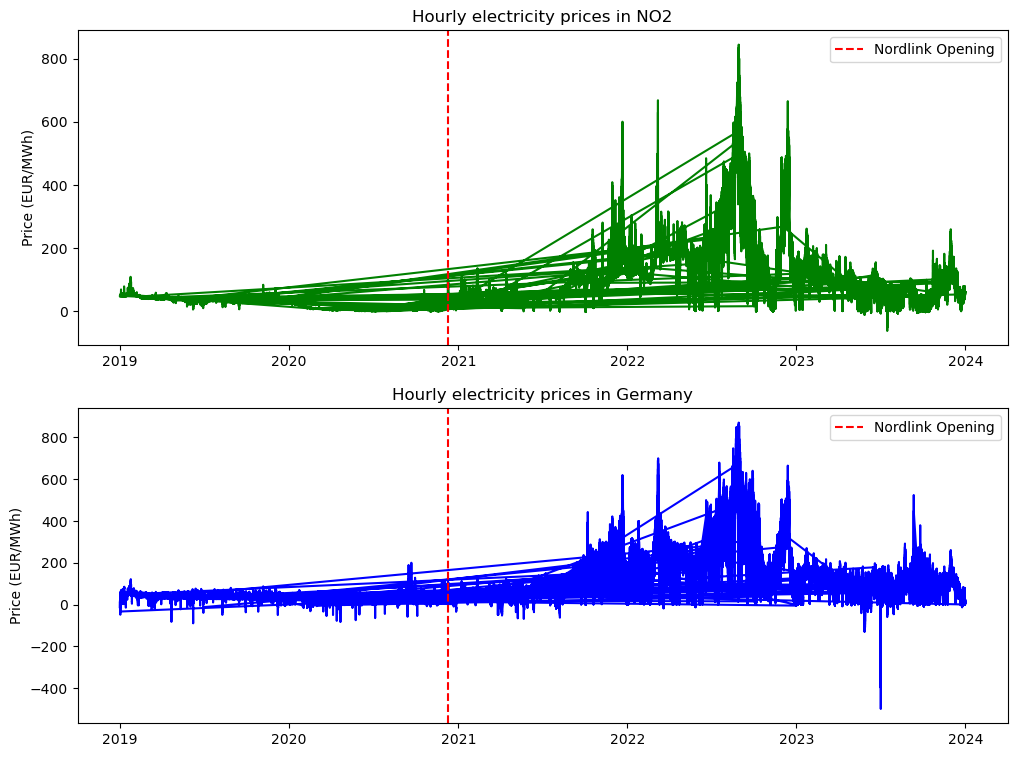

In [28]:
# Variables previously defined:
# prices_df, exports, imports

df = prices_df

# Separating data to  NO2 and Germany
price_data_no2 = df[df['MapCode'] == "NO2"]
price_data_germany = df[df['MapCode'] == "DE_LU"]

# Making graphs
fig, ax = plt.subplots(2,1, figsize = (12,9))


#Plotting NO2
ax[0].plot(price_data_no2['DateTime'], price_data_no2['Price'], color='green')
#Adding vertical line to indicate openinig of Nordlink
ax[0].axvline(pd.Timestamp('2020-12-09'), color='red', ls='--', label='Nordlink Opening')
ax[0].set_ylabel("Price (EUR/MWh)")
ax[0].set_title("Hourly electricity prices in NO2")
ax[0].legend()

# Plotting Germany
ax[1].plot(price_data_germany['DateTime'], price_data_germany['Price'], color='blue')
ax[1].axvline(pd.Timestamp('2020-12-09'), color='red', ls="--", label="Nordlink Opening")
ax[1].set_title('Hourly electricity prices in Germany')
ax[1].set_ylabel("Price (EUR/MWh)")
ax[1].legend()

# Saving the graph as figure_task1.png
plt.savefig("figure_task1.png")
plt.show()

# Closing the plot to free up memory
plt.close()


#### CONCLUSION

From the graph, it is noticable that after opening of Nordlink both prices in NO2 and Germany started to increased. The highest peak was observed late September 2022 at the price above 800 euros. After that prices have decresed and in July 2023 the price had dropped so much that it was even minus (in Germany -500 euros), perhaps due to convergence of high renewable generation and low demand season as it is summer.On sunny and  windy days, renewable energy generation can increase sharply, sometimes producing more electricity than is needed, just from renewable sources alone.

# Task 2

In [29]:
# Variables previously defined:
# prices_df

df = prices_df

# Extracting the year from DateTime
df['Year'] = df['DateTime'].dt.year

# Grouping by year and MapCode to calculate descriptive statistics
stats = df.groupby(['Year', 'MapCode'])['Price'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()

# Rounding the statistics to two decimal places
stats = stats.round(2)

# Saving to an Excel file with one sheet
stats.to_excel('table_task2.xlsx', index=False, header=True)

# Displaying the statistics table
print("Descriptive Statistics:")
print(stats)

Descriptive Statistics:
   Year MapCode    mean  median     std     min     max
0  2019   DE_LU   37.67   38.06   15.52  -90.01  121.46
1  2019     NO2   39.26   38.81    8.23    5.86  109.45
2  2020   DE_LU   30.47   30.99   17.50  -83.94  200.04
3  2020     NO2    9.29    6.95    8.26   -1.73   99.92
4  2021   DE_LU   96.85   75.48   73.68  -69.00  620.00
5  2021     NO2   75.11   59.34   47.22   -1.97  600.16
6  2022   DE_LU  235.44  208.34  142.82  -19.04  871.00
7  2022     NO2  211.28  181.13  125.85    0.04  844.00
8  2023   DE_LU   95.18   98.02   47.58 -500.00  524.27
9  2023     NO2   79.44   80.46   36.28  -61.84  261.85



This is how the table looks like in Excel
![excel_picture](excel_picture.png)

#### CONCLUSION

The prices seem to have become more extreme the last few years. They have become higher as well. The last year, however has shown a break in the trend where the prices are less volatile and also lower than previous years. 

# Task 3

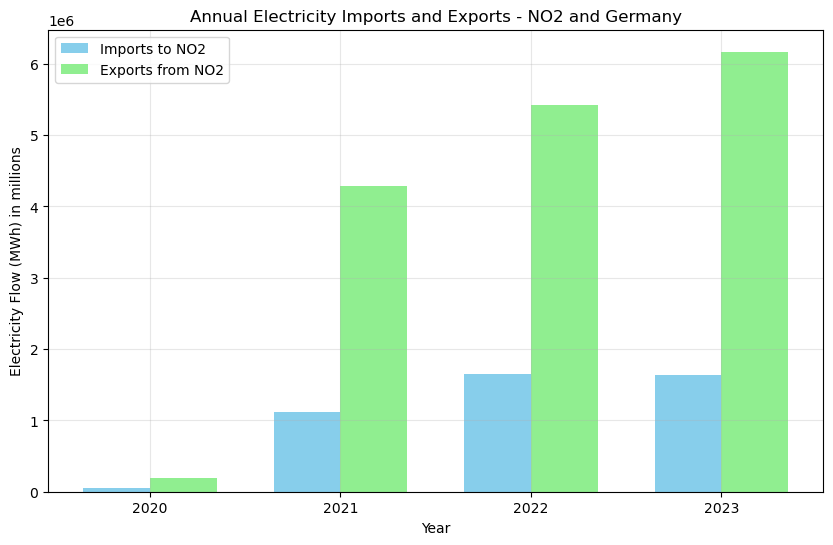

In [30]:

# Variables previously defined:
# exports, imports

# Resampling the data to yearly sum
yearly_exports = exports.resample('YE').sum()
yearly_imports = imports.resample('YE').sum()


# Creating the bar plot
plt.figure(figsize=(10, 6))

# Extracting the year from the index
x = yearly_exports.index.year

# Defining the width of the bars
bar_width = 0.35

# Plotting the bars
plt.bar(x - bar_width/2, yearly_imports, bar_width, label='Imports to NO2', color='skyblue')
plt.bar(x + bar_width/2, yearly_exports, bar_width, label='Exports from NO2', color='lightgreen')

# Adding labels, title, grid and legend
plt.xlabel('Year')
plt.ylabel('Electricity Flow (MWh) in millions')
plt.title('Annual Electricity Imports and Exports - NO2 and Germany')
plt.legend()
plt.grid(True, alpha=0.3)

# Displaying years on x axis
plt.xticks(x, [int(year) for year in x])


# Saving plot as png file
plt.savefig('figure_task3.png')

# Showing the plot
plt.show()

# Closing the plot to free up memory
plt.close()


#### CONCLUSION

NO2 exports more electricity than it imports from Germany with Nordlink. The annual sums of exports have grown rapidly over the years, while the annual sums of imports have been relatively stable. As you can observe from the graph, Nordlink was not operational before 2020.


# Task 4

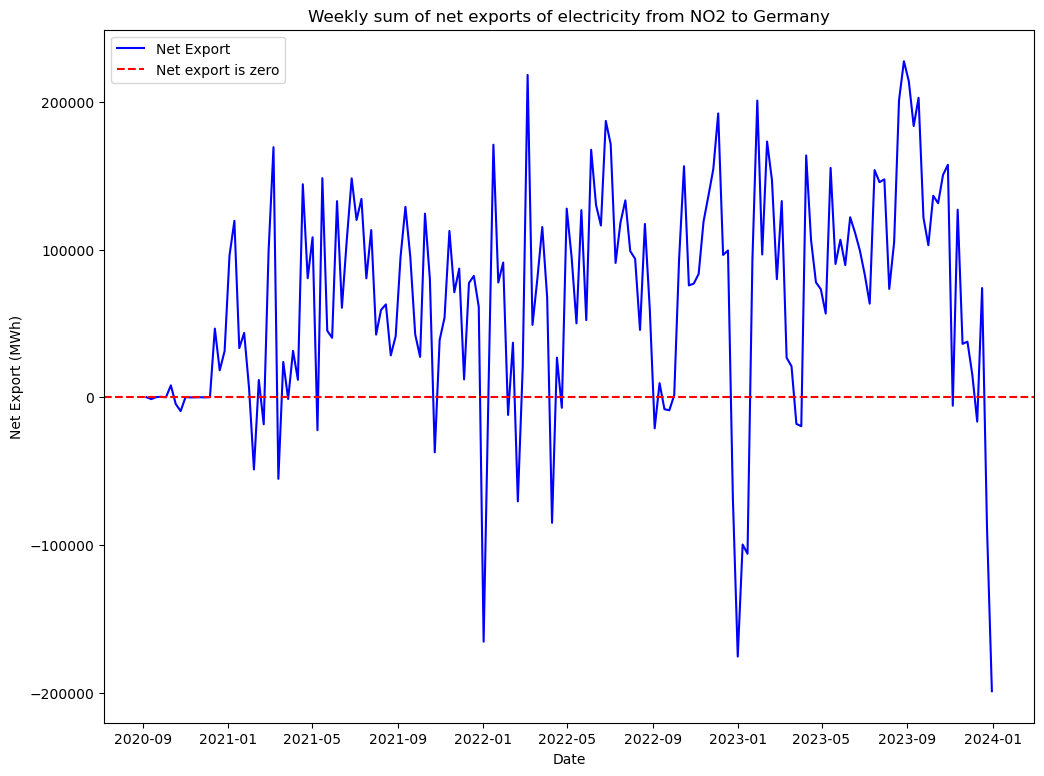

In [31]:

# Variables previously defined:
# exports, imports

# Resampling the data to hourly sum
hourly_exports = exports.resample('h').sum()
hourly_imports = imports.resample('h').sum()

# Calculating net exports (exports - imports)
net_exports = hourly_exports - hourly_imports

# Summing up net exports for each week
weekly_net_exports = net_exports.resample('W').sum()

# Plotting
plt.figure(figsize=(12, 9))
plt.plot(weekly_net_exports.index, weekly_net_exports, label='Net Export ', color='blue')

#Adding a horizontal line to demonstrate net export is zero
plt.axhline(0, color='red', linestyle='--', label='Net export is zero')
plt.title('Weekly sum of net exports of electricity from NO2 to Germany')
plt.xlabel("Date")
plt.ylabel("Net Export (MWh)")
plt.legend()

# Saving the plot as figure_task4.png
plt.savefig("figure_task4.png")
plt.show()

# Closing the plot to free up memory
plt.close()


#### CONCLUSION

Based on the graph, most of the time NO2 had exported electricity to Germany, but not always. Periods were there were significant dips in net exporting, indicating net importing from Germany were in January, especially in 2022, 2023 and 2024. This means that NO2 imports from Germany mostly during winter.

# Task 5

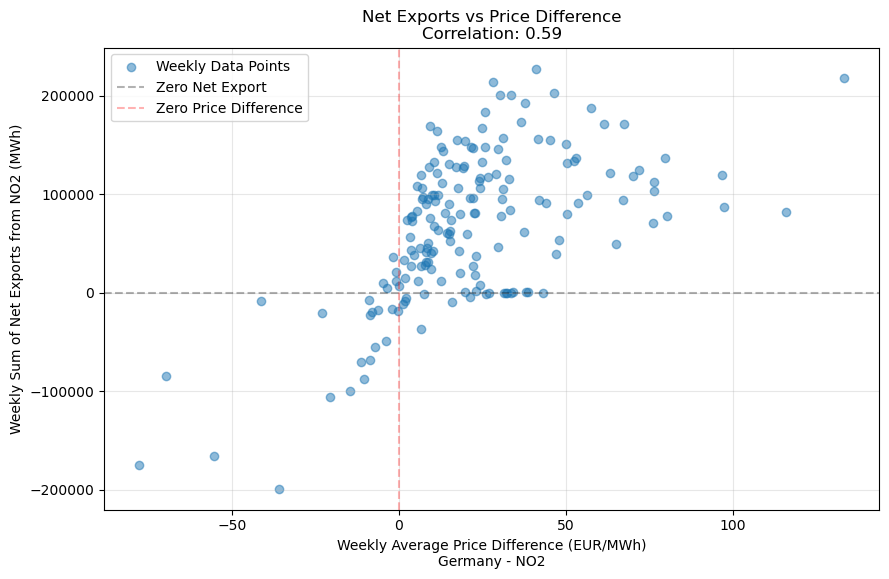

In [39]:
# Variables previously defined:
# price_data_no2, price_data_germany, weekly_net_exports


# Calculating hourly price differences (DE - NO2)
price_diff = pd.merge(price_data_germany, price_data_no2, on='DateTime', suffixes=('_DE', '_NO2'))
price_diff['price_difference'] = price_diff['Price_DE'] - price_diff['Price_NO2']

# Calculating weekly average price differences
weekly_price_diff = price_diff.set_index('DateTime')['price_difference'].resample('W').mean()


# Merging weekly data
weekly_data = pd.DataFrame({
    'price_diff': weekly_price_diff,
    'net_exports': weekly_net_exports
}).dropna()

# Calculating correlation coefficient
correlation = weekly_data['price_diff'].corr(weekly_data['net_exports'])

# Creating scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(weekly_data['price_diff'], weekly_data['net_exports'], 
           alpha=0.5, label='Weekly Data Points')

# Adding zero lines with labels
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3, label='Zero Net Export')  
plt.axvline(x=0, color='red', linestyle='--', alpha=0.3, label='Zero Price Difference')  

# Adding labels, title, grid and legend
plt.xlabel('Weekly Average Price Difference (EUR/MWh)\nGermany - NO2')
plt.ylabel('Weekly Sum of Net Exports from NO2 (MWh)')
plt.title(f'Net Exports vs Price Difference\nCorrelation: {correlation:.2f}')
plt.grid(True, alpha=0.3)
plt.legend()

# Saving the plot as figure_task5.png
plt.savefig('figure_task5.png')

# Showing the plot
plt.show()

# Closing the plot to free up memory
plt.close()




#### CONCLUSION
The correlation coefficient of 0.59 suggests a moderate positive relationship between the weekly average price difference and weekly sum of net exports. This indicates that NO2 tends to export more electricity to Germany when the price in Germany is higher relative to NO2.

# Task 6

We have used various sources to help us write our code. Some of the most used are [`Stack Overflow`](https://stackoverflow.com/) and [`Pandas'`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_excel.html) own website to find functions or how to best use them. We used ChatGPT to resolve errors that incur while writing the code, as it gave direct proposals how and where to make changes.

In many cases there was plenty of help provided in reviewing past lecutres and workshops as there are clear explanations and guidings to using the relevant fuctions in similar situations. 

We have not taken any code snippets from external sources that needs to be referenced.
